In [1]:
import sys, os
#%load_ext autoreload
#%autoreload 2
import torch
import torchvision
import torch.nn.functional as F
import torch.multiprocessing as mp
import torch.distributions as distrib
import torch.nn as nn
import torch.utils.data as td
from torch.utils.data import Dataset, DataLoader
import gym
import numpy as np
%matplotlib notebook
#%matplotlib tk
import random
import matplotlib.pyplot as plt
import foundation as fd
import foundation.util as util
from foundation import nets
#from foundation.envs.MNIST_envs import MNIST_Walker
import time

In [2]:
num_workers = 2

In [3]:
traindata = torchvision.datasets.MNIST('data/mnist/', train=True, download=True, transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.MNIST('data/mnist/', train=False, download=True, transform=torchvision.transforms.ToTensor())

In [20]:
model = nets.make_MLP(28*28, 10, hidden_dims=[64], nonlin='elu')
optim = nets.get_optimizer('adam', model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
model

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ELU(alpha=1.0, inplace)
  (2): Linear(in_features=64, out_features=10, bias=True)
)

In [16]:
model[0].weight.is_shared()

False

In [6]:
trainloader = DataLoader(traindata, batch_size=64, shuffle=True)
testloader = DataLoader(testdata, batch_size=128, shuffle=False)

In [ ]:
class Coach(mp.Process):
    def __init__(self, model, loader, ):
        pass

In [12]:
def run_epoch(model, loader, mode='test', optim=None, criterion=None, epoch=None):
    
    if mode == 'train':
        train = True
        model.train()
    else:
        train = False
        model.eval()
        
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
        
    stats = util.StatsMeter('loss')
        
    pfreq = max(1, len(loader)//100)
    for i, sample in enumerate(loader):
        
        x, y = sample
        
        pred = model(x.view(-1, 28*28))
        loss = criterion(pred, y)
        
        stats.update('loss', loss.detach())
        
        if optim is not None:
            optim.zero_grad()
            loss.backward()
            optim.step()
        
        if i % pfreq == 0:
            header = '' if epoch is None else 'Epoch {}: '.format(epoch)
            print('Mode {} {}Iteration [{}/{}] Loss: {:.3f} ({:.3f})'.format(
                mode, header, i+1, len(loader), stats['loss'].val, stats['loss'].avg))
            
            
    return stats


def run_parallel_epoch(pid, model, loader, mode='test', optim=None, criterion=None, epoch=None):
    if epoch is None:
        epoch = pid
        
    return run_epoch(model, loader, mode, optim, criterion, epoch)
    
        

In [21]:
pool = mp.Pool(num_workers)

In [22]:
pool.starmap(run_epoch, [(model, trainloader, 'train', optim, criterion)]*2)

Traceback (most recent call last):
  File "/home/fleeb/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-e17c7a2aa39d>", line 1, in <module>
    pool.starmap(run_epoch, [(model, trainloader, 'train', optim, criterion)]*2)
  File "/home/fleeb/anaconda3/lib/python3.5/multiprocessing/pool.py", line 274, in starmap
    return self._map_async(func, iterable, starmapstar, chunksize).get()
  File "/home/fleeb/anaconda3/lib/python3.5/multiprocessing/pool.py", line 638, in get
    self.wait(timeout)
  File "/home/fleeb/anaconda3/lib/python3.5/multiprocessing/pool.py", line 635, in wait
    self._event.wait(timeout)
  File "/home/fleeb/anaconda3/lib/python3.5/threading.py", line 549, in wait
    signaled = self._cond.wait(timeout)
  File "/home/fleeb/anaconda3/lib/python3.5/threading.py", line 293, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the abo

KeyboardInterrupt: 

In [14]:
#run_epoch(model, trainloader, 'true', optim, criterion)

In [19]:
#run_parallel_epoch(0, model, trainloader, 'true', optim, criterion)

In [17]:
workers = mp.spawn(run_parallel_epoch, args=(model, trainloader, 'train', optim, criterion), nprocs=num_workers, daemon=True)

Exception: process 1 terminated with exit code 1

In [ ]:
mp.

In [3]:
#env = MNIST_Walker(batch_size=5, sparse_reward=False)

In [4]:
state = env.reset()
state.size(), env.lbl_state

(torch.Size([5, 1, 28, 28]), tensor([ 3,  9,  3,  6,  1]))

In [20]:
state, reward, _, _ = env.step([ 0,0,1,2,2])
env.lbl_state, reward

(tensor([ 0,  0,  3,  9,  9]), tensor([ 0,  0, -3, -9, -9]))

<IPython.core.display.Javascript object>


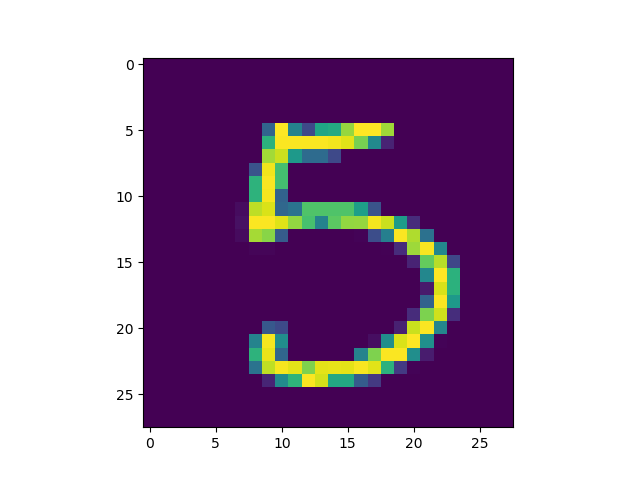

In [8]:
plt.figure()
plt.imshow(state[0,0].numpy())

In [20]:
for imgs, lbls in trainloader:
    break
imgs.size(), lbls.size()

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

In [51]:
class Encoder(nn.Module):
    def __init__(self, in_shape=(1,28,28), latent_dim=2, meta_dim=0, nonlin='prelu'):
        super(Encoder, self).__init__()
        
        assert latent_dim + meta_dim > 0
        
        self.conv, self.conv_dout = fd.nets.make_conv_net(in_shape=in_shape, 
                                                          nonlin=nonlin, output_nonlin=nonlin,
                                                          channels=[4,8,16], 
                                                          kernels=[7,5,3], 
                                                          pooling=[True]*3,)
        self.fc_din = np.prod(self.conv_dout)
        
        self.fc = fd.nets.make_MLP(input_dim=self.fc_din+meta_dim, 
                                   hidden_dims=[32], 
                                   output_dim=latent_dim,
                                   nonlinearity=nonlin,
                                  )
        
    def forward(self, x, m=None):
        
        y = self.conv(x).view(-1, self.fc_din)
        
        if m is not None:
            m = m.view(-1, self.meta_dim)
            y = torch.cat([y, m],-1)
        
        return self.fc(y)

#encoder = Encoder()
#print(encoder)
model = Encoder(latent_dim=10)
print(model)

Encoder(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): PReLU(num_parameters=1)
    (4): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): PReLU(num_parameters=1)
    (8): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): PReLU(num_parameters=1)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=32, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Line

In [ ]:
trainloader = DataLoader(traindata, batch_size=1, shuffle=False)

<IPython.core.display.Javascript object>


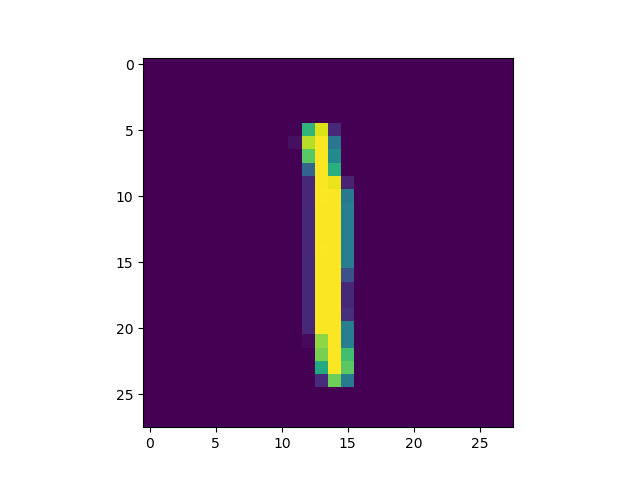

In [32]:
plt.figure()
plt.imshow(imgs[14].numpy())